In [1]:
import skimage as sk
import matplotlib.pyplot as plt
import numpy as np
import tifffile as tiff
from copy import copy
from scipy.spatial.distance import directed_hausdorff

In [5]:
gt = sk.io.imread('./../../../ppujol/mypose_benchmark/tp0/clear_wrinkled_cells_tp0-1.tif')
mp = sk.io.imread('./../../../ppujol/mypose_benchmark/tp0/labels_cell.tif')
cp = sk.io.imread('./../../../ppujol/mypose_benchmark/tp0/modified_wrinkled_cells_tp0_denoised_cp_masks.tif')

In [7]:
## Functions
def label_enclosed_regions(grid, value):
    # Create a binary mask where value is set to True and everything else is False
    mask = (grid == value)
    # Label connected components in the binary mask
    labeled_mask = sk.measure.label(mask, connectivity=1)
    
    # Initialize a dictionary to store mapping between region labels and unique numbers
    label_to_number = {}
    next_label = 1
    
    # Iterate over unique labels (excluding background label 0)
    for region_label in np.unique(labeled_mask)[1:]:
        # Assign a unique number to each enclosed region
        label_to_number[region_label] = next_label
        next_label += 1
    
    # Create a copy of the original grid
    labeled_grid = np.copy(grid)
    
    # Replace the original values with the corresponding unique numbers for each enclosed region
    for region_label, unique_number in label_to_number.items():
        labeled_grid[labeled_mask == region_label] = unique_number
    
    return labeled_grid

def normalize_image(im, mult_factor = 1):
    '''
    Normalize image (any Dimensions) function.
    '''
    im = np.array(im)
    norm_im = (im - im.min()) / (im.max()-im.min()) * mult_factor
    return norm_im

def reverse_values(im):
    rev_im = im.max()-im
    return rev_im

def get_r(image):
    image_r = np.transpose(image, axes=(1,0,2))
    return image_r

def get_top(image_r):
    image = np.transpose(image_r, axes=(1, 2, 0))
    image = np.rot90(image, axes=(1,2))
    return image

def dice_coefficient(mask1, mask2):
    intersection = np.sum(mask1 & mask2)
    total_size = np.sum(mask1) + np.sum(mask2)
    return 2.0 * intersection / total_size

def jaccard_similarity(mask1, mask2):
    intersection = np.sum(mask1 & mask2)
    union = np.sum(mask1 | mask2)
    return intersection / union

def hausdorff_distance(mask1, mask2):
    points_mask1 = np.argwhere(mask1)
    points_mask2 = np.argwhere(mask2)
    
    if len(points_mask1) == 0 or len(points_mask2) == 0:
        return float('inf')  # One of the masks is empty
    
    dist1 = directed_hausdorff(points_mask1, points_mask2)[0]
    dist2 = directed_hausdorff(points_mask2, points_mask1)[0]
    
    return max(dist1, dist2)

def mean_absolute_error(mask1, mask2):
    return np.mean(np.abs(mask1.astype(float) - mask2.astype(float)))

def root_mean_squared_error(mask1, mask2):
    return np.sqrt(np.mean(np.square(mask1.astype(float) - mask2.astype(float))))

def cell_mask(labels, labels_indices):
    d3_masked_image = copy(labels)
    mask_complete = np.isin(d3_masked_image, labels_indices)
    d3_masked_image[~mask_complete] =  0
    d3_masked_image[d3_masked_image!=0] = 1
    return d3_masked_image


Text(0.5, 1.0, 'Cellpose')

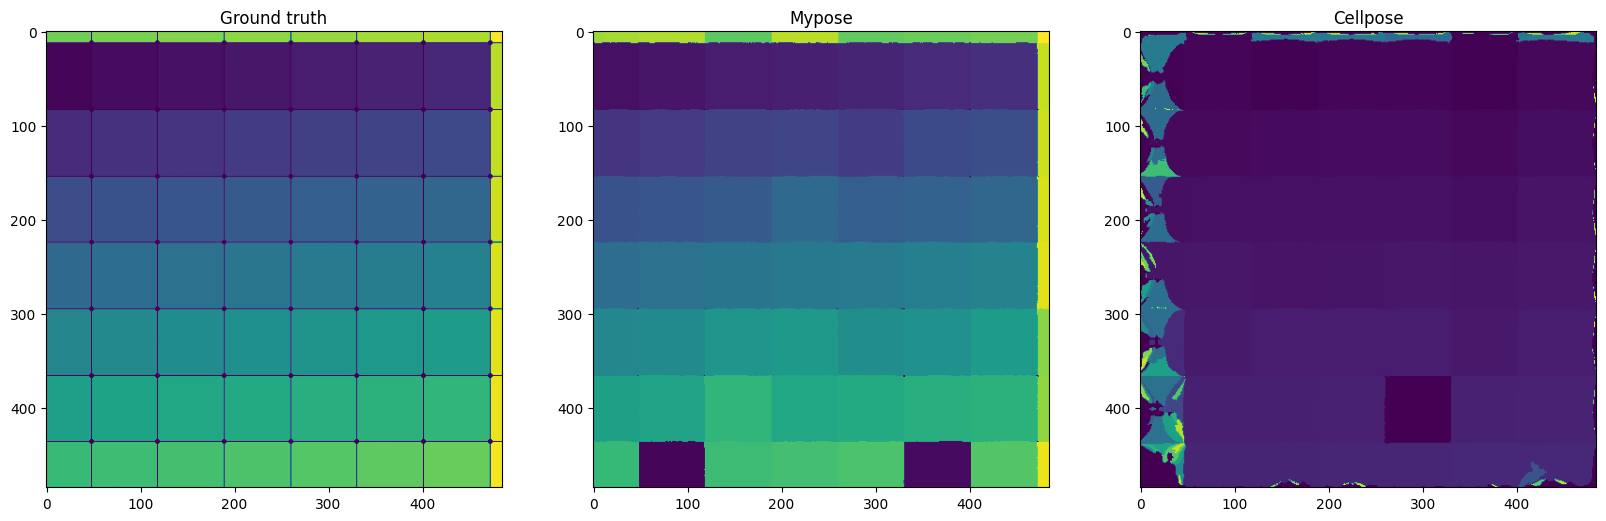

In [28]:
z = 200
gt_labeled = label_enclosed_regions(gt, 0)
gt_labeled = sk.morphology.dilation(gt_labeled, sk.morphology.ball(2)) ## Dilate the mask, before it was 2


plt.figure(figsize=(20,6))
plt.subplot(131)
plt.imshow(gt_labeled[z])
plt.title('Ground truth')
plt.subplot(132)
plt.imshow(mp[z])
plt.title('Mypose')
plt.subplot(133)
plt.imshow(cp[z])
plt.title('Cellpose')



In [29]:
# tiff.imwrite('./../ppujol/mypose_benchmark/tp0/clear_wrinkled_cells_tp0-labeled.tif', gt_labeled.astype(np.uint16), imagej=True)

In [30]:
###### tp 0
gt_labels = [3,4,5,6,7,8,10,11,12,13,14,15,17,18,19,20,21,22,24,25,26,27,28,29,31,32,33,34,35,36,38,39,40,41,42,43]
mp_labels = [5,6,7,8,9,10,12,14,15,13,16,17,19,20,24,21,22,23,26,27,28,29,30,31,33,36,37,34,35,38,40,45,41,42,43,44]
cp_labels = [6,2,7,8,3,9,12,13,14,15,10,16,19,20,21,22,17,23,28,24,25,29,26,30,32,33,34,35,31,36,38,39,40,1,41,42]
###### end tp 0
print(len(gt_labels), len(mp_labels), len(cp_labels))

36 36 36


In [31]:
gt_single = cell_mask(gt_labeled, gt_labels)
mp_single = cell_mask(mp, mp_labels)
cp_single = cell_mask(cp, cp_labels)

In [32]:
print("Mypose")
print("Dice coefficient:", dice_coefficient(gt_single, mp_single))
print("Jaccard similarity:", jaccard_similarity(gt_single, mp_single))
print("Mean Absolute Error:", mean_absolute_error(gt_single, mp_single))
print("Root Mean Squared Error:", root_mean_squared_error(gt_single, mp_single))
print("Cellpose")
print("Dice coefficient:", dice_coefficient(gt_single, cp_single))
print("Jaccard similarity:", jaccard_similarity(gt_single, cp_single))
print("Mean Absolute Error:", mean_absolute_error(gt_single, cp_single))
print("Root Mean Squared Error:", root_mean_squared_error(gt_single, cp_single))

Mypose
Dice coefficient: 0.9724456427537306
Jaccard similarity: 0.9463690518132549
Mean Absolute Error: 0.0074745456477840365
Root Mean Squared Error: 0.08645545470231497
Cellpose
Dice coefficient: 0.9022461192769089
Jaccard similarity: 0.8219020083833354
Mean Absolute Error: 0.029067502745598186
Root Mean Squared Error: 0.17049194334512757


In [33]:
def get_results(mask1, mask2):
    result = []
    result.append(dice_coefficient(mask1, mask2))
    result.append(jaccard_similarity(mask1, mask2))
    result.append(mean_absolute_error(mask1, mask2))
    result.append(root_mean_squared_error(mask1, mask2))
    return result

In [34]:
mp_VS_gt = []
cp_VS_gt = []

for g_l, m_l, c_l in zip(gt_labels, mp_labels, cp_labels):
    gt_single = cell_mask(gt_labeled, g_l)
    mp_single = cell_mask(mp, m_l)
    cp_single = cell_mask(cp, c_l)

    mp_VS_gt.append(get_results(gt_single, mp_single))
    cp_VS_gt.append(get_results(gt_single, cp_single))

mp_VS_gt = np.array(mp_VS_gt)
cp_VS_gt = np.array(cp_VS_gt)

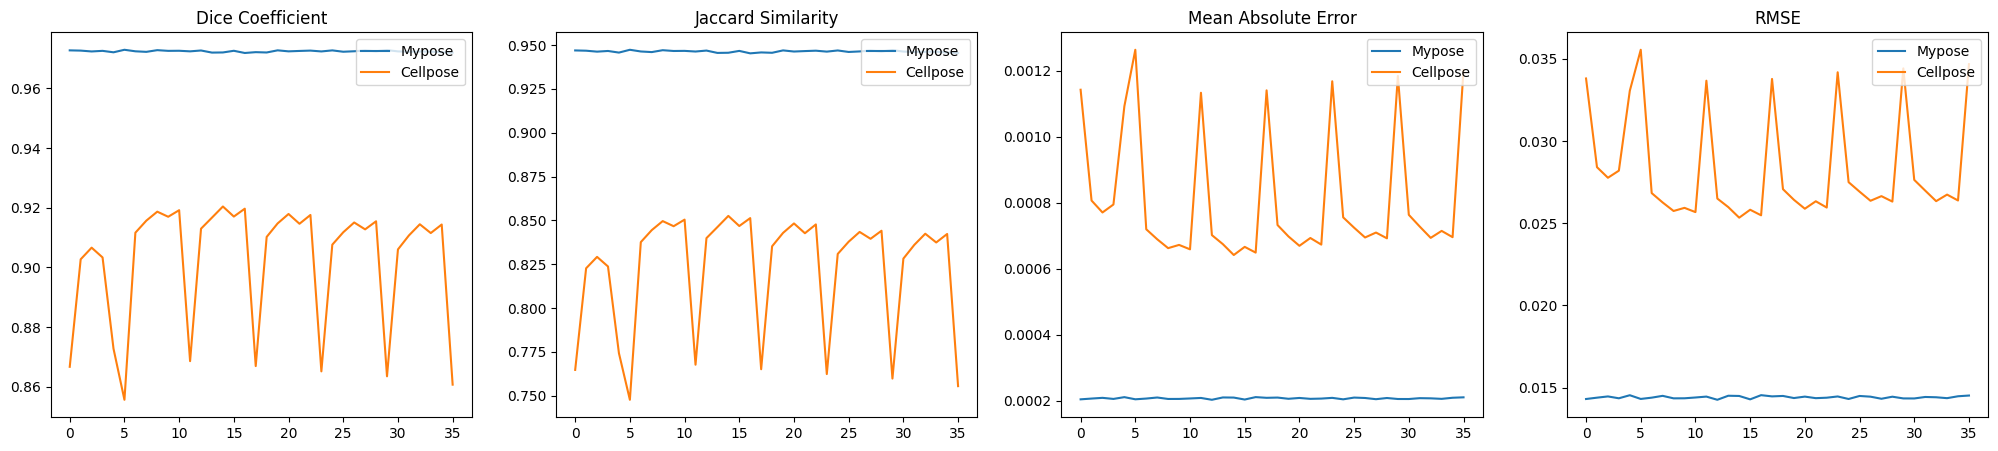

In [35]:
plt.figure(figsize=(25,5))
plt.subplot(141)
plt.plot(mp_VS_gt[:,0], label='Mypose')
plt.plot(cp_VS_gt[:,0], label='Cellpose')
plt.title("Dice Coefficient")
plt.legend(loc='upper right')
plt.subplot(142)
plt.plot(mp_VS_gt[:,1], label='Mypose')
plt.plot(cp_VS_gt[:,1], label='Cellpose')
plt.title("Jaccard Similarity")
plt.legend(loc='upper right')
plt.subplot(143)
plt.plot(mp_VS_gt[:,2], label='Mypose')
plt.plot(cp_VS_gt[:,2], label='Cellpose')
plt.title("Mean Absolute Error")
plt.legend(loc='upper right')
plt.subplot(144)
plt.plot(mp_VS_gt[:,3], label='Mypose')
plt.plot(cp_VS_gt[:,3], label='Cellpose')
plt.title("RMSE")
plt.legend(loc='upper right')

In [36]:
print(cp_VS_gt[:,3].mean())
print(mp_VS_gt[:,3].mean())

0.028239895284338217
0.014409096719707708


: 